State Schema With DataClasses (Beverage Example)

- When we define a LangGraph StateGraph, we use a state schema.
- The state schema represents the structure and type of data that the graph will work with.
- All nodes in the graph communicate using this schema.
- LangGraph allows flexibility in defining the state schema using TypedDict, dataclasses,or even Pydantic.
- Here, we’ll demonstrate TypedDict and dataclasses using a beverage selection workflow.

we can use the TypedDict class from python's typing module.
It allows you to specify keys and their corresponding value types.
But, note that these are type hints.
They can be used by static type checkers (like mypy) or IDEs to catch potential type-related errors before the code is run.
But they are not enforced at runtime!

# Why we use TypedDict & Dataclasses in LangGraph

LangGraph passes **state** between nodes. **TypedDict** and **Dataclasses** define the **state schema** (structure & types of data).

## TypedDict
- Dictionary-style state with type hints.
- Lightweight, JSON-friendly.
- Runtime not enforced: wrong types still run.
- **Example:** `graph.invoke({"name": 123}) ✅ works even if int`.

## Dataclass
- Object-style state, type-safe.
- Supports defaults, runtime validation.
- Must pass correct types: `graph.invoke(DataClassState(name="Alice")) ✅ works`.

## Benefits in LangGraph
- Predictable state structure
- Safe conditional logic
- Easier debugging & visualization
- IDE autocomplete & type checking


| Aspect            | TypedDict                                                                         | Dataclass                                                                                                                   |
| ----------------- | --------------------------------------------------------------------------------- | --------------------------------------------------------------------------------------------------------------------------- |
| Input flexibility | You can pass any dictionary at runtime (`{"name": 123}`) — no runtime type check. | You **must** pass an instance of the dataclass (`State(name="Alice")`). If you pass a dict, it will raise an error.         |
| Type enforcement  | Only type hints, not enforced at runtime.                                         | Dataclass enforces structure (field names), but Python doesn’t strictly enforce types at runtime unless you add validation. |


✅ Takeaway:

TypedDict = more flexible for quick experiments.

Dataclass = safer, structured, better for large/complex graphs, but stricter.

In [ ]:
# # TypedDict
# graph.invoke({"name": 123})  # ✅ works, even if '123' is int

# # Dataclass
# graph.invoke({"name": 123})  # ❌ TypeError, must do:
# graph.invoke(State(name=123))  # ✅ works


Literal - fixed set of allowed values

# 1️⃣ TypedDict Version

A dictionary with type hints (TypedDict) for keys/values

In [ ]:
from typing_extensions import TypedDict
from typing import Literal
import random
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END


In [ ]:
# ---------------------------
# Define the state schema
# ---------------------------
class TypedDictState(TypedDict):
    name: str
    beverage: Literal["Tea", "Coffee"]

In [7]:
# ---------------------------
# Node functions
# ---------------------------
def choose_beverage(state: TypedDictState):
    print("---Choose Beverage node has been called---")
    return {"name": str(state['name']) + " wants a beverage"}

def tea(state: TypedDictState):
    print("-- Tea node has been called --")
    return {"name": str(state['name']) + " chose Tea", "beverage": "Tea"}

def coffee(state: TypedDictState):
    print("-- Coffee node has been called --")
    return {"name": str(state['name']) + " chose Coffee", "beverage": "Coffee"}

In [9]:
# ---------------------------
# Decide function - FIXED
# ---------------------------
def decide_beverage(state: TypedDictState) -> Literal["tea", "coffee"]:
    # Make sure we return the exact node names that exist in the graph
    choice = "tea" if random.random() < 0.5 else "coffee"
    print(f"---Decision: going to {choice} node---")
    return choice


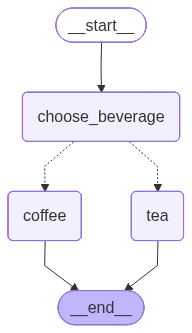

In [10]:
# ---------------------------
# Build the graph - FIXED STRUCTURE
# ---------------------------
builder = StateGraph(TypedDictState)

# Add nodes
builder.add_node("choose_beverage", choose_beverage)
builder.add_node("tea", tea)
builder.add_node("coffee", coffee)

# Define flow - FIXED EDGES
builder.add_edge(START, "choose_beverage")
builder.add_conditional_edges(
    "choose_beverage",
    decide_beverage,
    {
        "tea": "tea",      # Maps to tea node
        "coffee": "coffee"  # Maps to coffee node
    }
)
builder.add_edge("tea", END)
builder.add_edge("coffee", END)

# Compile and display graph
graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:
# ---------------------------
# Invoke the graph
# ---------------------------
print("\n=== First invocation ===")
result1 = graph.invoke({"name": "Alice"})
print(f"Final result: {result1}")


=== First invocation ===
---Choose Beverage node has been called---
---Decision: going to tea node---
-- Tea node has been called --
Final result: {'name': 'Alice wants a beverage chose Tea', 'beverage': 'Tea'}


In [12]:


print("\n=== Second invocation ===")
result2 = graph.invoke({"name": 123})
print(f"Final result: {result2}")


=== Second invocation ===
---Choose Beverage node has been called---
---Decision: going to tea node---
-- Tea node has been called --
Final result: {'name': '123 wants a beverage chose Tea', 'beverage': 'Tea'}


### Dataclasses
A Python class for structured data, primarily storing attributes

In [13]:
from dataclasses import dataclass
from typing import Literal
import random
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END


In [14]:
@dataclass
class DataClassState:
    name: str
    beverage: Literal["Tea", "Coffee"] = None  # Make beverage optional

In [15]:

def choose_beverage(state: DataClassState):
    print("---Choose Beverage node has been called---")
    # Return as dictionary for state update
    return {"name": state.name + " wants a beverage"}

def tea(state: DataClassState):
    print("-- Tea node has been called --")
    return {"name": state.name + " chose Tea", "beverage": "Tea"}

def coffee(state: DataClassState):
    print("-- Coffee node has been called --")
    return {"name": state.name + " chose Coffee", "beverage": "Coffee"}

In [16]:
# Fixed: Add explicit mapping for conditional edges
def decide_beverage(state: DataClassState) -> Literal["tea", "coffee"]:
    choice = "tea" if random.random() < 0.5 else "coffee"
    print(f"---Decision: going to {choice} node---")
    return choice

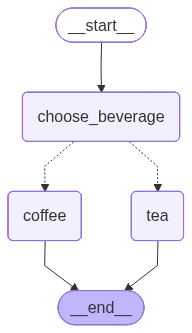

In [17]:
builder = StateGraph(DataClassState)
builder.add_node("choose_beverage", choose_beverage)
builder.add_node("tea", tea)
builder.add_node("coffee", coffee)

builder.add_edge(START, "choose_beverage")
# FIXED: Add explicit mapping for conditional edges
builder.add_conditional_edges(
    "choose_beverage",
    decide_beverage,
    {
        "tea": "tea",
        "coffee": "coffee"
    }
)
builder.add_edge("tea", END)
builder.add_edge("coffee", END)

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [18]:

# FIXED: Invoke with proper initial state
graph.invoke(DataClassState(name="Alice", beverage=None))

---Choose Beverage node has been called---
---Decision: going to tea node---
-- Tea node has been called --


{'name': 'Alice wants a beverage chose Tea', 'beverage': 'Tea'}

In [19]:
# Alternative: Invoke with dictionary instead of dataclass instance
graph.invoke({"name": "123", "beverage": None})

---Choose Beverage node has been called---
---Decision: going to coffee node---
-- Coffee node has been called --


{'name': '123 wants a beverage chose Coffee', 'beverage': 'Coffee'}